# Michael Boles
# Data challenge: customer cliff dive

### Prompt and executive summary
* Yammer has seen a sharp decline in weekly active users (WAUs)
 * Where did it come from?
 * What to do about it?

## Load data set

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# adjust view settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# adjust plot settings
plt.rcParams["font.family"] = "Helvetica"
# plt.style.use("bmh")
# plt.rcParams.update({"axes.facecolor" : "white",
#                      "axes.edgecolor":  "black"})

In [3]:
# import data set
data_users = pd.read_csv('./data/yammer_users.csv')
data_events_1 = pd.read_csv('./data/yammer_events_1.csv')
data_events_2 = pd.read_csv('./data/yammer_events_2.csv')
data_emails = pd.read_csv('./data/yammer_emails.csv')

In [4]:
# combine events tables
data_events = pd.concat([data_events_1, data_events_2])

## Initial analysis

In [144]:
# print first entries
data_users.head()
# data_events.head()
# data_emails.head()

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active


In [6]:
# # print pandas profiling report
# from pandas_profiling import ProfileReport
# profile = ProfileReport(data_events, title='Pandas Profiling Report', html={'style':{'full_width': True}})
# profile.to_notebook_iframe()

## Data wrangling

In [154]:
# recast 'ocurred at' column to datetime format for events and emails table
data_users['created_at'] = pd.to_datetime(data_users['created_at'])

data_events['occurred_at'] = pd.to_datetime(data_events['occurred_at'])
# data_events.dtypes

data_emails['occurred_at'] = pd.to_datetime(data_emails['occurred_at'])
# data_emails.dtypes

In [155]:
# data_users.iloc[:400:10]

In [156]:
# group events table by user and week
events_grouped_user_week = data_events.groupby(['user_id', pd.Grouper(key='occurred_at', freq='W-MON')]).count()['user_type'].reset_index()
events_grouped_user_week.columns = ['user_id', 'occurred_at', 'number']
events_grouped_user_week

# group grouped (user, week) table by week to get total weekly active users
events_grouped_week = events_grouped_user_week.groupby(['occurred_at']).sum().reset_index().drop(columns=['user_id'])
# events_grouped_week

In [164]:
# group users table by language and week
users_grouped_language_week = data_users.groupby(['language', pd.Grouper(key='created_at', freq='W-MON')]).count()['user_id'].reset_index()
users_grouped_language_week_pivot = users_grouped_language_week.pivot(index='created_at', columns='language', values='user_id')
users_grouped_language_week_pivot_norm = users_grouped_language_week_pivot.divide(users_grouped_language_week_pivot.iloc[0])
top_ten_languages = users_grouped_language_week_pivot.sum().sort_values(ascending=False)[:10].index.to_list()

# group users table by state and week
users_grouped_state_week = data_users.groupby(['state', pd.Grouper(key='created_at', freq='W-MON')]).count()['user_id'].reset_index()
users_grouped_state_week_pivot = users_grouped_state_week.pivot(index='created_at', columns='state', values='user_id')
users_grouped_state_week_pivot_norm = users_grouped_state_week_pivot.divide(users_grouped_state_week_pivot.iloc[0])

In [139]:
# group events table by event name and week
events_grouped_eventname_week = data_events.groupby(['event_name', pd.Grouper(key='occurred_at', freq='W-MON')]).count()['user_type'].reset_index()
events_grouped_eventname_week_pivot = events_grouped_eventname_week.pivot(index='occurred_at', columns='event_name', values='user_type')
events_grouped_eventname_week_pivot_norm = events_grouped_eventname_week_pivot.divide(events_grouped_eventname_week_pivot.iloc[0]).drop(columns=['create_user', 'enter_email', 'enter_info'])

# group events table by location and week
events_grouped_location_week = data_events.groupby(['location', pd.Grouper(key='occurred_at', freq='W-MON')]).count()['user_type'].reset_index()
events_grouped_location_week_pivot = events_grouped_location_week.pivot(index='occurred_at', columns='location', values='user_type')
events_grouped_location_week_pivot_norm = events_grouped_location_week_pivot.divide(events_grouped_location_week_pivot.iloc[0])
top_ten_countries = events_grouped_location_week_pivot.sum().sort_values(ascending=False)[:10].index.to_list()

# group events table by location and week
events_grouped_device_week = data_events.groupby(['device', pd.Grouper(key='occurred_at', freq='W-MON')]).count()['user_type'].reset_index()
events_grouped_device_week_pivot = events_grouped_device_week.pivot(index='occurred_at', columns='device', values='user_type')
events_grouped_device_week_pivot_norm = events_grouped_device_week_pivot.divide(events_grouped_device_week_pivot.iloc[0])
top_ten_devices = events_grouped_device_week_pivot.sum().sort_values(ascending=False)[:10].index.to_list()

In [79]:
# group emails table by user and week

emails_grouped_user_week = data_emails.groupby(['user_id', pd.Grouper(key='occurred_at', freq='W-MON')]).count()['user_type'].reset_index()
# emails_grouped_user_week[:20]

# group grouped (user, week) table by week to get total weekly active users
emails_grouped_week = emails_grouped_user_week.groupby(['occurred_at']).sum()
emails_grouped_week.columns = ['occurred_at', 'number']
# emails_grouped_week

## Data visualization

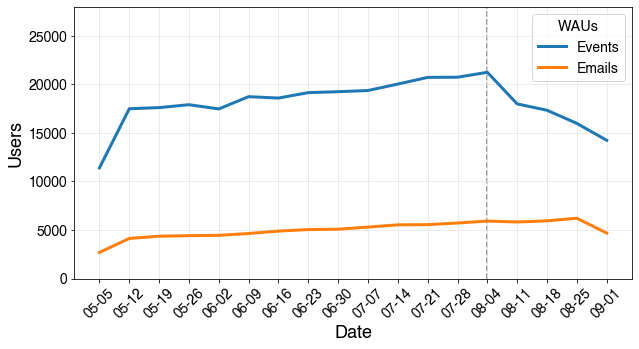

In [102]:
# plot weekly active users
fig, axes = plt.subplots(1, 1, figsize=(10,5))

# stipulate data of interest
x = events_grouped_week['occurred_at'].dt.strftime('%m-%d')
y1 = events_grouped_week['number']
y2 = emails_grouped_week['number']

# plot data
plt.plot(x, y1, linewidth=3, zorder= 2, label='Events')
plt.plot(x, y2, linewidth=3, zorder= 3, label='Emails')

# set legend, plot properties
l = plt.legend(loc=1, prop={'size': 14}, title='WAUs')
plt.setp(l.texts, family='Helvetica')
plt.setp(l.get_title(),fontsize='x-large')

plt.xlabel('Date', fontsize=18, fontname='Helvetica')
plt.ylabel('Users', fontsize=18, fontname='Helvetica')
plt.tick_params(axis = 'x', labelsize = 14, rotation=45)
plt.tick_params(axis = 'y', labelsize = 14)
plt.grid(color=(.9, .9, .9))
plt.ylim(0, 28000)
plt.axvline(x='08-04', linestyle='--', c='gray', zorder=0)

# display plot
plt.show()

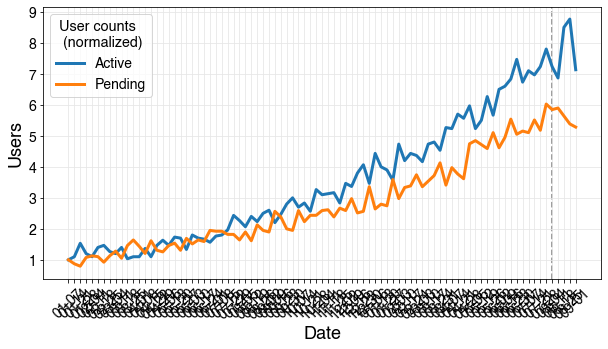

In [179]:
# plot weekly active users
fig, axes = plt.subplots(1, 1, figsize=(10,5))

# stipulate data of interest
x = users_grouped_state_week_pivot_norm.index.strftime('%m-%d')
y1 = users_grouped_state_week_pivot_norm['active']
y2 = users_grouped_state_week_pivot_norm['pending']

# plot data
plt.plot(x, y1, linewidth=3, zorder= 2, label='Active')
plt.plot(x, y2, linewidth=3, zorder= 3, label='Pending')

# set legend, plot properties
l = plt.legend(loc=2, prop={'size': 14}, title='User counts \n (normalized)')
plt.setp(l.texts, family='Helvetica')
plt.setp(l.get_title(),fontsize='x-large')

plt.xlabel('Date', fontsize=18, fontname='Helvetica')
plt.ylabel('Users', fontsize=18, fontname='Helvetica')
plt.tick_params(axis = 'x', labelsize = 14, rotation=45)
plt.tick_params(axis = 'y', labelsize = 14)
plt.grid(color=(.9, .9, .9))
# plt.ylim(0, 28000)
plt.axvline(x='08-04', linestyle='--', c='gray', zorder=0)

# display plot
plt.show()

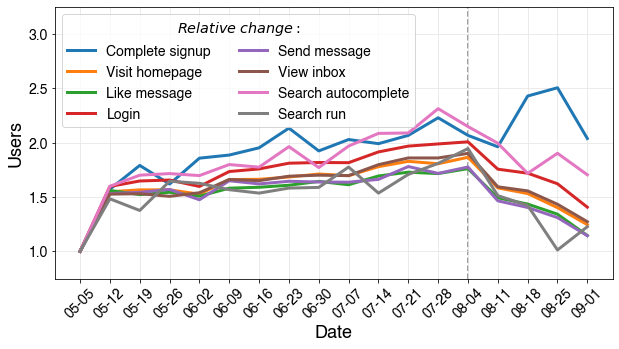

In [134]:
# plot relative changes to weekly actions
fig, axes = plt.subplots(1, 1, figsize=(10,5))

# stipulate data of interest
x = events_grouped_eventname_week_pivot_norm.index.strftime('%m-%d')
y1 = events_grouped_eventname_week_pivot_norm['complete_signup']
y2 = events_grouped_eventname_week_pivot_norm['home_page']
y3 = events_grouped_eventname_week_pivot_norm['like_message']
y4 = events_grouped_eventname_week_pivot_norm['login']
y5 = events_grouped_eventname_week_pivot_norm['send_message']
y6 = events_grouped_eventname_week_pivot_norm['view_inbox']
y7 = events_grouped_eventname_week_pivot_norm['search_autocomplete']
y8 = events_grouped_eventname_week_pivot_norm['search_run']

# plot data
plt.plot(x, y1, linewidth=3, zorder= 2, label='Complete signup')
plt.plot(x, y2, linewidth=3, zorder= 3, label='Visit homepage')
plt.plot(x, y3, linewidth=3, zorder= 3, label='Like message')
plt.plot(x, y4, linewidth=3, zorder= 3, label='Login')
plt.plot(x, y5, linewidth=3, zorder= 3, label='Send message')
plt.plot(x, y6, linewidth=3, zorder= 3, label='View inbox')
plt.plot(x, y7, linewidth=3, zorder= 3, label='Search autocomplete')
plt.plot(x, y8, linewidth=3, zorder= 3, label='Search run')

# set legend, plot properties
l = plt.legend(loc=2, ncol=2, prop={'size': 14}, title='$Relative$ $change:$')
plt.setp(l.texts, family='Helvetica')
plt.setp(l.get_title(),fontsize='x-large')

plt.xlabel('Date', fontsize=18, fontname='Helvetica')
plt.ylabel('Users', fontsize=18, fontname='Helvetica')
plt.tick_params(axis = 'x', labelsize = 14, rotation=45)
plt.tick_params(axis = 'y', labelsize = 14)
plt.grid(color=(.9, .9, .9))
plt.ylim(0.75, 3.25)
plt.axvline(x='08-04', linestyle='--', c='gray', zorder=0)

# display plot
plt.show()

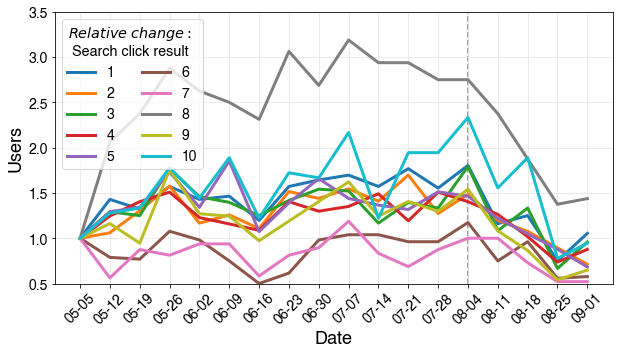

In [108]:
# plot relative changes to weekly actions
fig, axes = plt.subplots(1, 1, figsize=(10,5))

# stipulate data of interest
x = events_grouped_eventname_week_pivot_norm.index.strftime('%m-%d')
y1 = events_grouped_eventname_week_pivot_norm['search_click_result_1']
y2 = events_grouped_eventname_week_pivot_norm['search_click_result_2']
y3 = events_grouped_eventname_week_pivot_norm['search_click_result_3']
y4 = events_grouped_eventname_week_pivot_norm['search_click_result_4']
y5 = events_grouped_eventname_week_pivot_norm['search_click_result_5']
y6 = events_grouped_eventname_week_pivot_norm['search_click_result_6']
y7 = events_grouped_eventname_week_pivot_norm['search_click_result_7']
y8 = events_grouped_eventname_week_pivot_norm['search_click_result_8']
y9 = events_grouped_eventname_week_pivot_norm['search_click_result_9']
y10 = events_grouped_eventname_week_pivot_norm['search_click_result_10']

# plot data
plt.plot(x, y1, linewidth=3, zorder= 2, label='1')
plt.plot(x, y2, linewidth=3, zorder= 3, label='2')
plt.plot(x, y3, linewidth=3, zorder= 3, label='3')
plt.plot(x, y4, linewidth=3, zorder= 3, label='4')
plt.plot(x, y5, linewidth=3, zorder= 3, label='5')
plt.plot(x, y6, linewidth=3, zorder= 3, label='6')
plt.plot(x, y7, linewidth=3, zorder= 3, label='7')
plt.plot(x, y8, linewidth=3, zorder= 3, label='8')
plt.plot(x, y9, linewidth=3, zorder= 3, label='9')
plt.plot(x, y10, linewidth=3, zorder= 3, label='10')

# set legend, plot properties
l = plt.legend(loc=2, ncol=2, prop={'size': 14}, title='$Relative$ $change:$ \n Search click result')
plt.setp(l.texts, family='Helvetica')
plt.setp(l.get_title(),fontsize='x-large')

plt.xlabel('Date', fontsize=18, fontname='Helvetica')
plt.ylabel('Users', fontsize=18, fontname='Helvetica')
plt.tick_params(axis = 'x', labelsize = 14, rotation=45)
plt.tick_params(axis = 'y', labelsize = 14)
plt.grid(color=(.9, .9, .9))
plt.ylim(0.5, 3.5)
plt.axvline(x='08-04', linestyle='--', c='gray', zorder=0)

# display plot
plt.show()

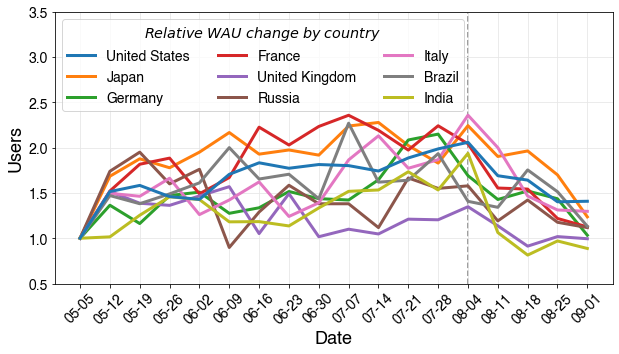

In [131]:
# plot relative changes to weekly visitors by country
fig, axes = plt.subplots(1, 1, figsize=(10,5))

# stipulate data of interest
x = events_grouped_eventname_week_pivot_norm.index.strftime('%m-%d')
y1 = events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,0]
y2 = events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,1]
y3 = events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,2]
y4 = events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,3]
y5 = events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,4]
y6 = events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,5]
y7 = events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,6]
y8 = events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,7]
y9 = events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,8]
y10 = events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,9]

# plot data
plt.plot(x, y1, linewidth=3, zorder= 4, label=events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,0].name)
plt.plot(x, y2, linewidth=3, zorder= 3, label=events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,1].name)
plt.plot(x, y3, linewidth=3, zorder= 3, label=events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,2].name)
plt.plot(x, y4, linewidth=3, zorder= 3, label=events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,3].name)
plt.plot(x, y5, linewidth=3, zorder= 3, label=events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,4].name)
plt.plot(x, y6, linewidth=3, zorder= 3, label=events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,5].name)
plt.plot(x, y7, linewidth=3, zorder= 3, label=events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,6].name)
plt.plot(x, y8, linewidth=3, zorder= 3, label=events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,7].name)
plt.plot(x, y9, linewidth=3, zorder= 3, label=events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,8].name)
# plt.plot(x, y10, linewidth=3, zorder= 3, label=events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,9].name)

# set legend, plot properties
l = plt.legend(loc=2, ncol=3, prop={'size': 14}, title='$Relative$ $WAU$ $change$ $by$ $country$')
plt.setp(l.texts, family='Helvetica')
plt.setp(l.get_title(),fontsize='x-large')

plt.xlabel('Date', fontsize=18, fontname='Helvetica')
plt.ylabel('Users', fontsize=18, fontname='Helvetica')
plt.tick_params(axis = 'x', labelsize = 14, rotation=45)
plt.tick_params(axis = 'y', labelsize = 14)
plt.grid(color=(.9, .9, .9))
plt.ylim(0.5, 3.5)
plt.axvline(x='08-04', linestyle='--', c='gray', zorder=0)

# display plot
plt.show()

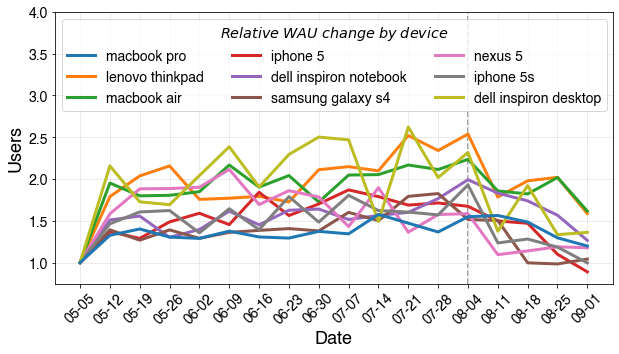

In [143]:
# plot relative changes to weekly visitors by device
fig, axes = plt.subplots(1, 1, figsize=(10,5))

# stipulate data of interest
x = events_grouped_eventname_week_pivot_norm.index.strftime('%m-%d')
y1 = events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,0]
y2 = events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,1]
y3 = events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,2]
y4 = events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,3]
y5 = events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,4]
y6 = events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,5]
y7 = events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,6]
y8 = events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,7]
y9 = events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,8]
y10 = events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,9]

# plot data
plt.plot(x, y1, linewidth=3, zorder= 4, label=events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,0].name)
plt.plot(x, y2, linewidth=3, zorder= 3, label=events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,1].name)
plt.plot(x, y3, linewidth=3, zorder= 3, label=events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,2].name)
plt.plot(x, y4, linewidth=3, zorder= 3, label=events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,3].name)
plt.plot(x, y5, linewidth=3, zorder= 3, label=events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,4].name)
plt.plot(x, y6, linewidth=3, zorder= 3, label=events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,5].name)
plt.plot(x, y7, linewidth=3, zorder= 3, label=events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,6].name)
plt.plot(x, y8, linewidth=3, zorder= 3, label=events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,7].name)
plt.plot(x, y9, linewidth=3, zorder= 3, label=events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,8].name)
# plt.plot(x, y10, linewidth=3, zorder= 3, label=events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,9].name)

# set legend, plot properties
l = plt.legend(loc=2, ncol=3, prop={'size': 14}, title='$Relative$ $WAU$ $change$ $by$ $device$')
plt.setp(l.texts, family='Helvetica')
plt.setp(l.get_title(),fontsize='x-large')

plt.xlabel('Date', fontsize=18, fontname='Helvetica')
plt.ylabel('Users', fontsize=18, fontname='Helvetica')
plt.tick_params(axis = 'x', labelsize = 14, rotation=45)
plt.tick_params(axis = 'y', labelsize = 14)
plt.grid(color=(.9, .9, .9))
plt.ylim(0.75, 4)
plt.axvline(x='08-04', linestyle='--', c='gray', zorder=0)

# display plot
plt.show()

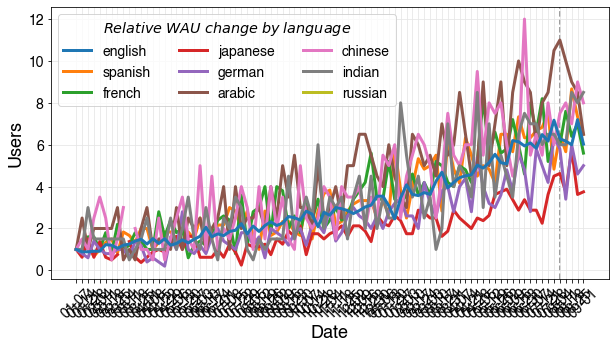

In [188]:
# plot relative changes to weekly visitors by language
fig, axes = plt.subplots(1, 1, figsize=(10,5))

# stipulate data of interest
x = users_grouped_language_week_pivot_norm.index.strftime('%m-%d')
y1 = users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,0]
y2 = users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,1]
y3 = users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,2]
y4 = users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,3]
y5 = users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,4]
y6 = users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,5]
y7 = users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,6]
y8 = users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,7]
y9 = users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,8]
y10 = events_grouped_device_week_pivot_norm[top_ten_devices].iloc[:,9]

# plot data
plt.plot(x, y1, linewidth=3, zorder= 4, label=users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,0].name)
plt.plot(x, y2, linewidth=3, zorder= 3, label=users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,1].name)
plt.plot(x, y3, linewidth=3, zorder= 3, label=users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,2].name)
plt.plot(x, y4, linewidth=3, zorder= 3, label=users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,3].name)
plt.plot(x, y5, linewidth=3, zorder= 3, label=users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,4].name)
plt.plot(x, y6, linewidth=3, zorder= 3, label=users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,5].name)
plt.plot(x, y7, linewidth=3, zorder= 3, label=users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,6].name)
plt.plot(x, y8, linewidth=3, zorder= 3, label=users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,7].name)
plt.plot(x, y9, linewidth=3, zorder= 3, label=users_grouped_language_week_pivot_norm[top_ten_languages].iloc[:,8].name)
# plt.plot(x, y10, linewidth=3, zorder= 3, label=events_grouped_location_week_pivot_norm[top_ten_countries].iloc[:,9].name)

# set legend, plot properties
l = plt.legend(loc=2, ncol=3, prop={'size': 14}, title='$Relative$ $WAU$ $change$ $by$ $language$')
plt.setp(l.texts, family='Helvetica')
plt.setp(l.get_title(),fontsize='x-large')

plt.xlabel('Date', fontsize=18, fontname='Helvetica')
plt.ylabel('Users', fontsize=18, fontname='Helvetica')
plt.tick_params(axis = 'x', labelsize = 14, rotation=45)
plt.tick_params(axis = 'y', labelsize = 14)
plt.grid(color=(.9, .9, .9))
# plt.ylim(0.75, 4)
plt.axvline(x='08-04', linestyle='--', c='gray', zorder=0)

# display plot
plt.show()